In [25]:
import scipy.io
import os 
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import numpy as np
import random

In [26]:
ls .

 Volume in drive C has no label.
 Volume Serial Number is 72CE-31B0

 Directory of c:\Users\mdiqb\Desktop\DOT_Reconstruction\Matlab_to_python_datatransfer\All_Data_300_9

05/09/2024  05:17 PM    <DIR>          .
05/09/2024  04:54 PM    <DIR>          ..
05/09/2024  05:22 PM         9,633,920 All_fine_meshes_300.npy
05/09/2024  05:22 PM         9,633,920 All_ground_truth_300.npy
05/09/2024  05:22 PM         1,016,192 All_measured_data_300.npy
05/09/2024  05:18 PM           138,321 matlab_to_data_extraction2.ipynb
04/28/2024  01:06 PM    <DIR>          ref
04/28/2024  12:52 PM    <DIR>          tar
               4 File(s)     20,422,353 bytes
               4 Dir(s)  417,665,372,160 bytes free


In [27]:
ref_mat_contents = scipy.io.loadmat('ref/ref_measured_data_300_9.mat')

In [28]:
measured_data_all_wavelengths = ref_mat_contents['measured_data_all_wavelengths']

In [29]:
new_ref = []
for i in range(1):
    all_wave = [] 
    for j in range(3): 
        all_wave.append(measured_data_all_wavelengths[0][j][0][i])
    all_wave = np.array(all_wave) 
    new_ref.append(all_wave)
        

In [30]:
new_ref = np.array(new_ref)

In [31]:
new_ref.shape

(1, 3, 9, 14)

In [32]:
angles = ['0']
#angles = ['-2', '-1', '0', '1', '2']

index_of_zero = angles.index('0')
print("Index of '0':", index_of_zero)

Index of '0': 0


In [33]:
DATA_DIR = "./tar"

In [34]:
file_list = os.listdir(DATA_DIR)

In [35]:
len(file_list)

168

In [36]:
sample_tar_mat_contents = scipy.io.loadmat('tar/measured_data_ua_0.012_rad_0.75_dep_0.5_0.mat')

In [37]:
sample_tar_mat_contents['measured_data'][0].shape

(9, 14)

In [38]:
sample_tar_mat_contents['uaDir'][0]

'ua_0.012'

In [39]:
def insert_sphere(array, depth, radius, mua = 1):
    z_range = np.linspace(0.5, 3.5, array.shape[0])
    x_range = np.linspace(-4, 4, array.shape[1])
    y_range = np.linspace(-4, 4, array.shape[2])
    
    # Get the index of the depth in the z-axis
    z_index = np.abs(z_range - depth).argmin()
    
    # Get the center index of the array
    center_x = array.shape[1] // 2
    center_y = array.shape[2] // 2
    center_z = z_index
    
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            for k in range(array.shape[0]):
                # Calculate distance from the center
                distance = np.sqrt((x_range[i] - 0) ** 2 + (y_range[j] - 0) ** 2 + (z_range[k] - depth) ** 2)
                if distance <= radius:
                    array[k, i, j] = mua  # or any other value you choose for the sphere
                
    return array

In [40]:
All_ground_truth = [] 
All_measured_data = [] 
All_fine_meshes = []

for j, file in enumerate(file_list):
    mat_contents = scipy.io.loadmat(f'{DATA_DIR}/{file}')
    #print(mat_contents)
    #break
    radiusDir = mat_contents['radiusDir']
    uaDir = mat_contents['uaDir']
    measured_data = mat_contents['measured_data']
    angleDir = mat_contents['angleDir']
    depthDir = mat_contents['depthDir']

    depth = float(str(depthDir[0]).split('_')[-1]) #*5/80
    radius = float(str(radiusDir[0]).split('_')[-1]) #*5/80
    ua = float(str(uaDir[0]).split('_')[-1])*10

    #print(depth, ua, radius)

    angle = str(angleDir[0]).split('_')[-1]

    angles = ['0']
    
    index = angles.index(angle)
    ref_measured = new_ref[index]

    #perturbation = np.concatenate([measured_data, ref_measured], axis = 1) 
    perturbation = (measured_data - ref_measured)/(ref_measured)
    pert_real = np.real(perturbation)
    pert_imag = np.imag(perturbation) 

    #print(pert_imag.shape) 
    pert = np.concatenate([pert_real, pert_imag], axis =1)
    pert = pert.reshape(-1, 14)
    pert = np.clip(pert, -2, 2)
    #print(pert.shape)
    #plt.figure()
    #plt.plot(np.imag(measured_data.reshape(-1))) 
    #plt.figure()
    #plt.plot(np.imag(ref_measured.reshape(-1)))
    #plt.figure()
    #plt.plot((np.real(measured_data)/np.real(ref_measured)).reshape(-1))
    #break
    

    array = np.zeros((7, 32,32)) 
    ground_truth = insert_sphere(array, depth, radius, ua)

    array = np.zeros((7, 32,32)) 
    fine_mesh = insert_sphere(array, depth, radius*random.uniform(1.5, 2.5))

    All_ground_truth.append(ground_truth) 
    All_measured_data.append(pert)
    All_fine_meshes.append(fine_mesh)


In [41]:
All_ground_truth = np.array(All_ground_truth) 
All_measured_data = np.array(All_measured_data)
All_fine_meshes = np.array(All_fine_meshes)


In [42]:
All_ground_truth.shape

(168, 7, 32, 32)

In [43]:
All_measured_data.min()

-0.889054470322175

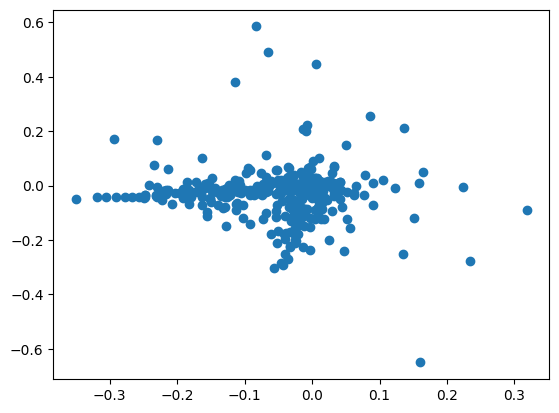

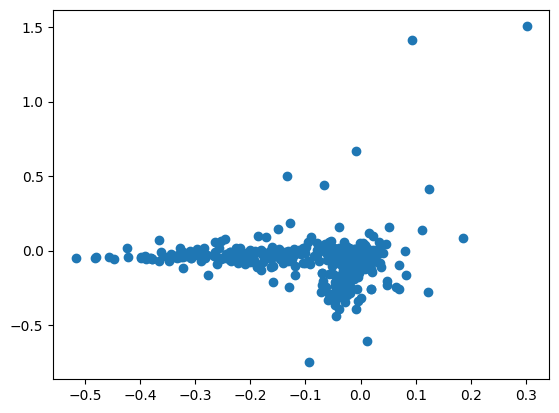

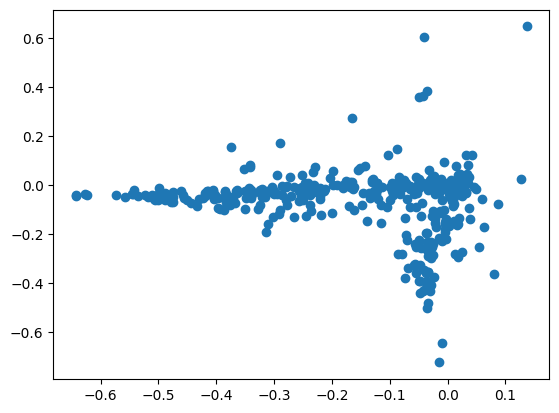

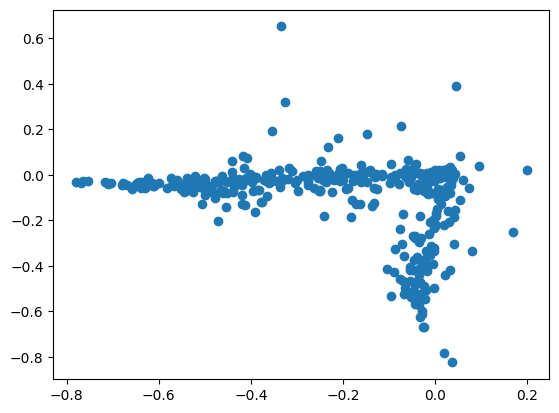

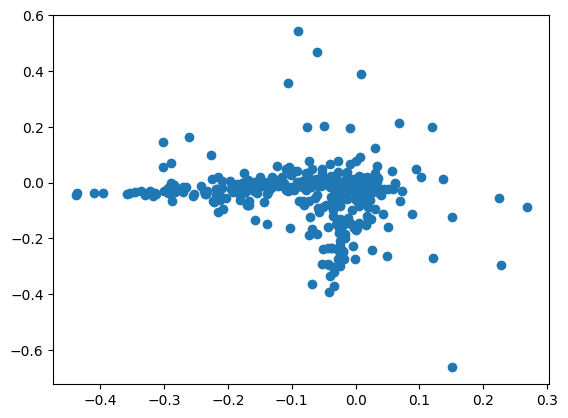

In [44]:
import matplotlib.pyplot as plt 
for i in range(0, 150, 30):
    plt.scatter(All_measured_data[i][:27,:], All_measured_data[i][27:, :])
    plt.show()

In [45]:
All_measured_data.shape

(168, 54, 14)

In [46]:
All_measured_data.max()

1.5247614105027332

In [47]:
All_measured_data.min()

-0.889054470322175

In [48]:
with open("All_measured_data_300.npy", "wb") as f: 
    np.save(f, All_measured_data)

with open("All_ground_truth_300.npy", "wb") as f: 
    np.save(f, All_ground_truth)

with open("All_fine_meshes_300.npy", "wb") as f: 
    np.save(f, All_fine_meshes)